<img src="DAT_512.png" width="300" height="140">

# Buffalo 311 Forecast
---
Cassie Kamens<br>
Class - DAT 512 <br> 
Institution- Canisuis College<br>
Professor- Paul Lambson<br>
Spring 2023 <br>
<br>
### Exploratory Objectives<br>
- Create a forecast for the number of Buffalo 311 calls made per day for 2023
- Determine the importance of holidays in prediction 311 calls in a day
<br>


### Sections
- [Data Import(API)-Buffalo 311 Calls](#data_import)
- [Data Cleaning](#Data_Cleaning)
- [Final Dataframe](#Final_Dataframe)
- [Prepare for Prophet](#Prophet_1)
- [Holiday Dataframe Creation](#Holiday_DF)
- [Prophet Holiday Model](#Prophet_2)
- [Prophet No Holiday Model](#Prophet_3)
- [Prophet Holiday Model 2.0](#Prophet_4)
- [Compare Models](#Comparison)

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
from datetime import date
import seaborn as sns
import holidays

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from prophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Data Import(API)- Buffalo 311 Calls
<a id='data_import'></a>

---
- Import the data from https://data.buffalony.gov/Quality-of-Life/311-Service-Requests/whkc-e5vr using an API <br>
- Check the connection to the API <br>
- All data matching the parameters will be imported into a dataframe <br>

In [2]:
uri = 'https://data.buffalony.gov/resource/whkc-e5vr.json'
r = requests.get(uri)
print('Status code ',r.status_code)
print('Number of rows returned ',len(r.json()))
print('Endoced URI with params ',r.url)

Status code  200
Number of rows returned  1000
Endoced URI with params  https://data.buffalony.gov/resource/whkc-e5vr.json


In [3]:
df=pd.DataFrame(r.json())
print(df.shape)

(1000, 48)


In [4]:
params_dict = {
    '$where':'date_extract_y(open_date)>2018',
    '$limit':1000000
}

uri = 'https://data.buffalony.gov/resource/whkc-e5vr.json'

r =requests.get(uri,params=params_dict)
print('Status code:',r.status_code)
print('Number of rows returned:',len(r.json()))
print('Endoced URI with params:',r.url)

Status code: 200
Number of rows returned: 354828
Endoced URI with params: https://data.buffalony.gov/resource/whkc-e5vr.json?%24where=date_extract_y%28open_date%29%3E2018&%24limit=1000000


In [5]:
df=pd.DataFrame(r.json())
print(df.shape)
df.head()

(354828, 33)


,case_reference,open_date,closed_date,status,subject,reason,type,object_type,address_number,address_line_1,...,census_tract_2010,census_block_group_2010,census_block_2010,tractce20,geoid20_tract,geoid20_blockgroup,geoid20_block,x_coordinate,y_coordinate,address_line_2
0,1001824819,2023-04-20T11:03:00.000,2023-04-26T08:08:00.000,Closed,Dept of Public Works,Sanitation,Recycling Missed Pick Up (Req_Serv),Property,69,ST JOHNS PKSD,...,10,3,3005,001000,36029001000,360290010003,360290010003005,NaN,NaN,NaN
1,1001804417,2023-03-06T10:47:00.000,2023-03-15T08:38:00.000,Closed,Utilities,National Grid,Streetlights (Req_Serv),Property,201,BARNARD,...,19,3,3000,001900,36029001900,360290019003,360290019003000,-8772599.988,5292287.5423,NaN
2,508695-1001788285,2023-02-05T20:15:00.000,2023-02-15T08:38:00.000,Closed,Utilities,National Grid,Streetlights (Req_Serv),Property,16,LOMBARD,...,16,4,4012,001602,36029001602,360290016021,360290016021031,-78.83721,42.88649,NaN
3,1001804204,2023-03-03T15:29:00.000,NaN,Open,Dept of Public Works,Engineering - Traffic,Sign Hazards (Req_Serv),Property,INTERSECTION,Lang Ave,...,37,1,1004,003700,36029003700,360290037001,360290037001004,1088168.1,1063669.6,Hagen St
4,1001803670,2023-03-01T15:01:00.000,2023-03-06T10:57:00.000,Closed,Dept of Public Works,Sanitation,Pick and Pay (Req_Serv),Property,3,VIOLA,...,33.01,2,2008,003301,36029003301,360290033012,360290033012006,-8777171.317,5299921.3636,NaN


# Data Cleaning
<a id='Data_Cleaning'></a>

---
- Change the format of open_date to be str variable <br>
- Create and call a function that will change the format of 'open_date' to be a datetime variable that includes the month, day, and year <br>
- Create a function that will pull the year of the date from a datetime variable <br> 
- Create a new column containing only the year of the open_date <br>

In [6]:
Buff_311_Calls_2 = pd.DataFrame({'open_date': df['open_date']})
Buff_311_Calls_2.head()

,open_date
0,2023-04-20T11:03:00.000
1,2023-03-06T10:47:00.000
2,2023-02-05T20:15:00.000
3,2023-03-03T15:29:00.000
4,2023-03-01T15:01:00.000


In [7]:
Buff_311_Calls_2.loc[:,'open_date'] = Buff_311_Calls_2.loc[:, 'open_date'].astype(str)

In [8]:
Buff_311_Calls_2.dropna()

def date(date1):
    try:
        newdate = datetime.datetime.strptime(date1,"%Y-%m-%dT%H:%M:%S.%f")
        final = newdate.strftime('%Y-%m-%d')
        return final
    except ValueError:
        faildate = datetime.datetime(2000,5,17)
        final = faildate.strftime('%Y-%m-%d')
        return final


Buff_311_Calls_2['open_date']=Buff_311_Calls_2.apply(lambda x : date(x['open_date']) , axis=1)

In [9]:
def year_only(date1):
    newdate = datetime.datetime.strptime(date1,"%Y-%m-%d")
    final = newdate.strftime('%Y')
    return final

Buff_311_Calls_2['start_year']=Buff_311_Calls_2.apply(lambda x : year_only(x['open_date']) , axis=1)

# Final Dataframe
<a id='Final_Dataframe'></a>

---
- Create a dataframe of all columns where the 'start_year' is not 2023<br> 
- Check to make sure that dates in 2023 are not in the dateframe<br>
- Drop the column 'start_year'<br>
- Add a column named 'num_of_calls<br> 
- Create a dataframe that counts the number of calls each day using the groupby function<br>

In [10]:
Buffalo_311 = pd.DataFrame(Buff_311_Calls_2.where(Buff_311_Calls_2['start_year'] != '2023')).dropna()

In [11]:
Buffalo_311['start_year'].unique()

array(['2022', '2021', '2020', '2019'], dtype=object)

In [12]:
del Buffalo_311['start_year']

In [13]:
Buffalo_311['num_of_calls'] = 1

In [14]:
Buffalo_311_GB = pd.DataFrame(Buffalo_311.groupby(['open_date'])['num_of_calls'].count())
Buffalo_311_GB = Buffalo_311_GB.reset_index()

# Prepare for Prophet
<a id='Prophet_1'></a>

---
- Create a dataframe using Buffalo_311_GB where 'open_date' is renamed 'ds' and 'num_of_calls' is renamed 'y'<br>
- Create an inital plot showing the trands for number of calls made to 311 each day from 2019 through 2022

In [15]:
prophet_df = Buffalo_311_GB.rename(columns={'open_date':'ds', 'num_of_calls':'y'})
prophet_df.head()

,ds,y
0,2019-01-01,13
1,2019-01-02,307
2,2019-01-03,251
3,2019-01-04,224
4,2019-01-05,19


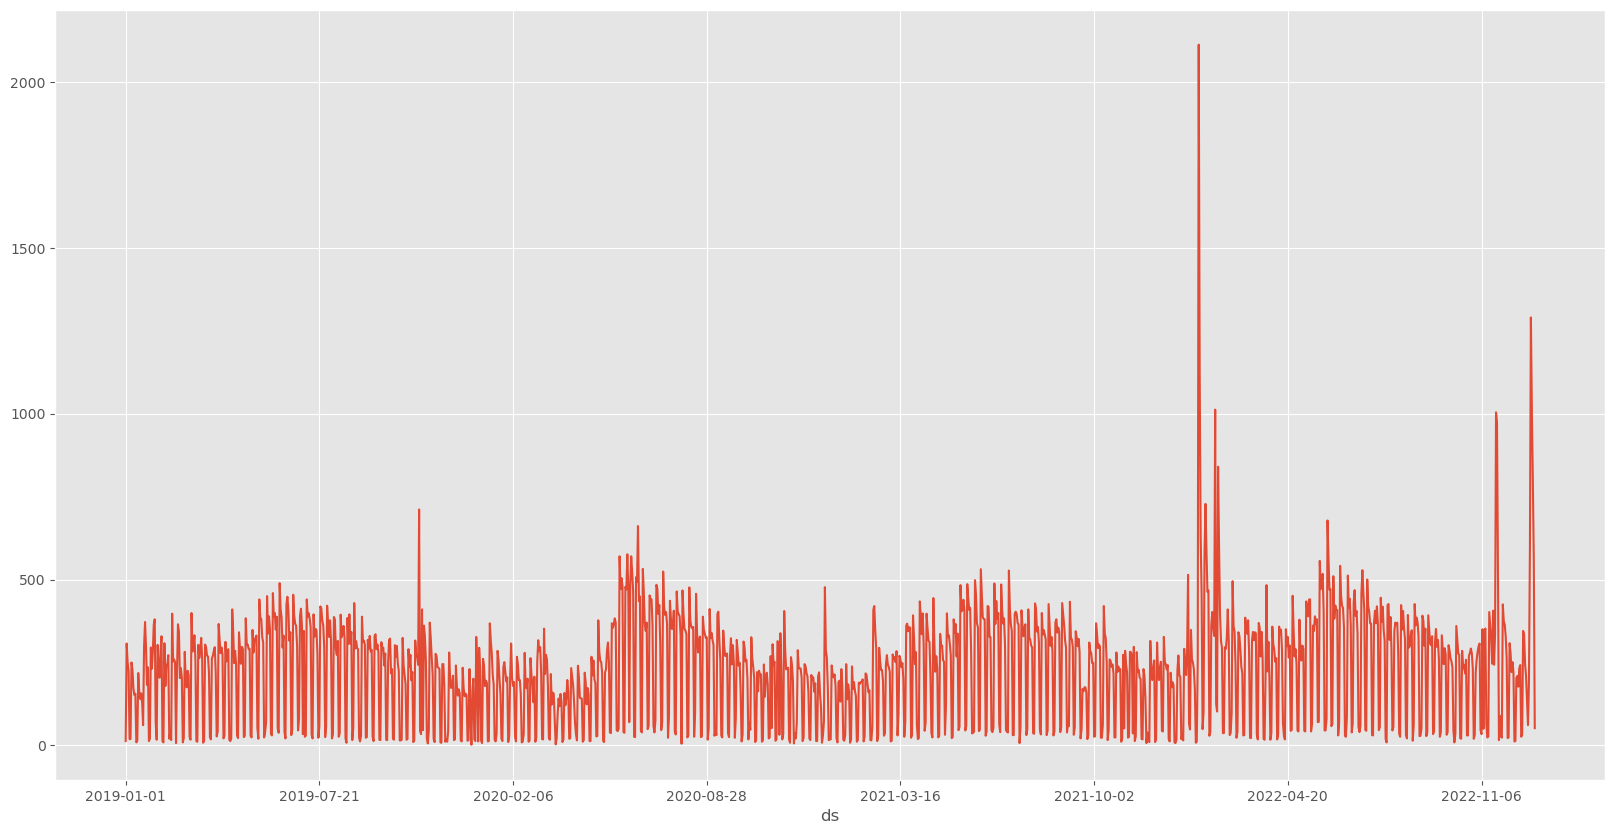

In [16]:
prophet_df.set_index('ds').y.plot();

# Holiday Dataframe
<a id='Holiday_DF'></a>

---
- Use the holidays model to create a dataframe of all of the holidays in 2019,2020,2021, and 2022 

In [17]:
us_holidays = holidays.UnitedStates(years = [2019,2020,2021,2022])

holidays = pd.DataFrame({
  'holiday': us_holidays.values(),
  'ds': us_holidays.keys(),
  'lower_window': 0,
  'upper_window': 0,
}) 
holidays.head()

,holiday,ds,lower_window,upper_window
0,New Year's Day,2019-01-01,0,0
1,Martin Luther King Jr. Day,2019-01-21,0,0
2,Washington's Birthday,2019-02-18,0,0
3,Memorial Day,2019-05-27,0,0
4,Independence Day,2019-07-04,0,0


# Prophet Holiday Model
<a id='Prophet_2'></a>

---
- Create a Prophet model including holidays and without weekly seasonality<br>
- Model for 12 months<br>
- Use the model to create predictions<br>
- Plot the model<br>
- Plot model components<br>

In [18]:
model = Prophet(holidays=holidays,
                weekly_seasonality=False)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(prophet_df)

12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future = model.make_future_dataframe(periods=12, freq = 'm')
future.tail()
forecast = model.predict(future)
forecast.head().T

,0,1,2,3,4
ds,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00
trend,208.514803,208.5155,208.516196,208.516892,208.517589
yhat_lower,-188.857446,-21.500926,2.713211,12.860412,-0.073324
yhat_upper,224.819491,400.584306,409.221213,417.811742,404.278599
trend_lower,208.514803,208.5155,208.516196,208.516892,208.517589
...,...,...,...,...,...
yearly_upper,-16.206756,-15.017201,-14.065697,-13.309503,-12.702083
multiplicative_terms,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_lower,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_upper,0.0,0.0,0.0,0.0,0.0


In [20]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1463,2023-08-31,332.112714,138.178896,529.258877
1464,2023-09-30,281.326003,81.111429,491.288777
1465,2023-10-31,256.912745,69.183049,465.470899
1466,2023-11-30,262.662962,53.440939,470.591946
1467,2023-12-31,302.674912,114.654361,507.735731


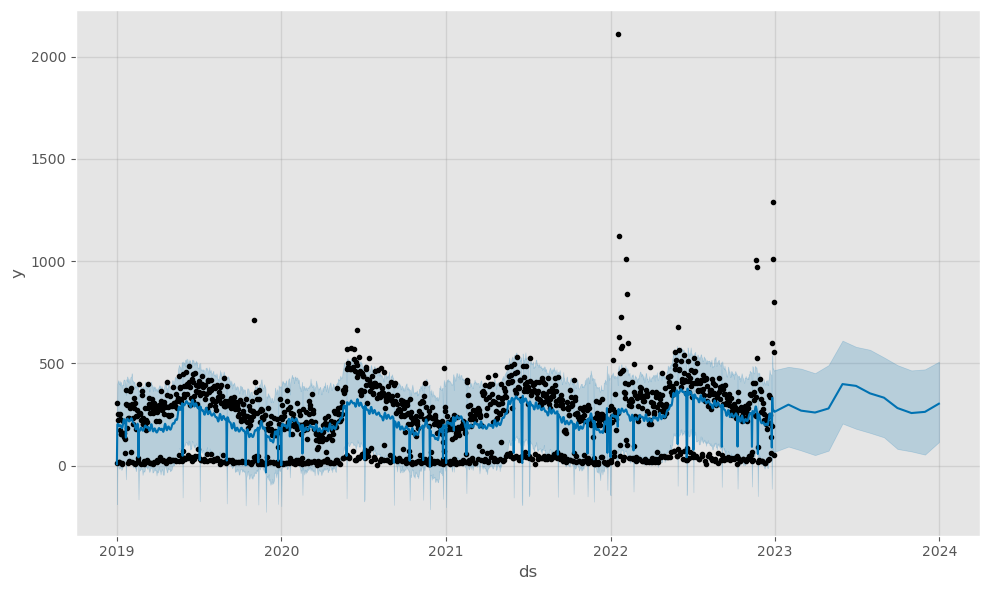

In [21]:
model.plot(forecast);

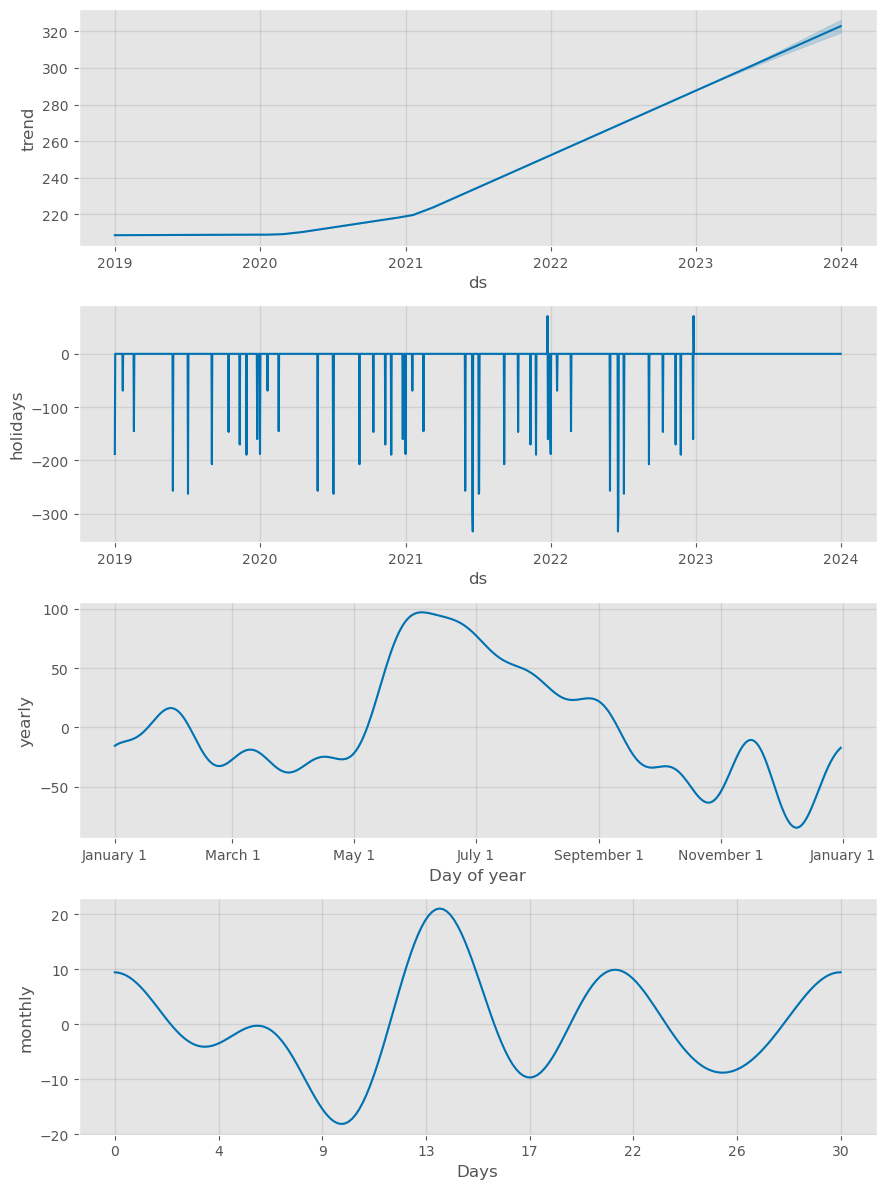

In [22]:
model.plot_components(forecast);

In [24]:
metric_df = pd.concat([forecast[['ds','yhat']],prophet_df['y']], axis=1)
metric_df.head()

,ds,yhat,y
0,2019-01-01,6.630328,13.0
1,2019-01-02,200.940909,307.0
2,2019-01-03,203.918670,251.0
3,2019-01-04,202.373062,224.0
4,2019-01-05,197.713909,19.0


In [25]:
metric_df.dropna(inplace = True)
print("R-squared: ", r2_score(metric_df['y'], metric_df['yhat']))
print("Mean Squared Error: ", mean_squared_error(metric_df['y'], metric_df['yhat']))
print("RMSE: ", np.sqrt(mean_squared_error(metric_df['y'], metric_df['yhat'])))

R-squared:  0.1325168767242093
Mean Squared Error:  24857.010062474357
RMSE:  157.66106070452005


# Prophet No Holiday Model
<a id='Prophet_3'></a>

---
- Create a Prophet model excluding holidays and without weekly seasonality<br>
- Model for 12 months<br>
- Use the model to create predictions<br>
- Plot the model<br>
- Plot model components<br>

In [26]:
model_no_holiday = Prophet()
model_no_holiday.fit(prophet_df)

12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future_no_holiday = model_no_holiday.make_future_dataframe(periods=12, freq = 'm')
future_no_holiday.tail()

,ds
1463,2023-08-31
1464,2023-09-30
1465,2023-10-31
1466,2023-11-30
1467,2023-12-31


In [28]:
forecast_no_holiday = model_no_holiday.predict(future)

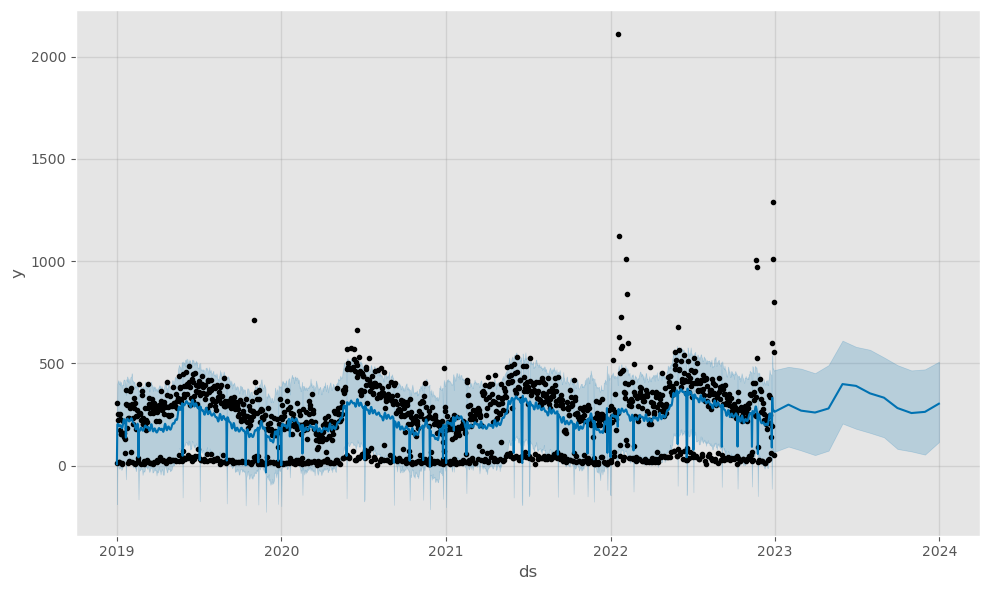

In [29]:
model_no_holiday.plot(forecast);

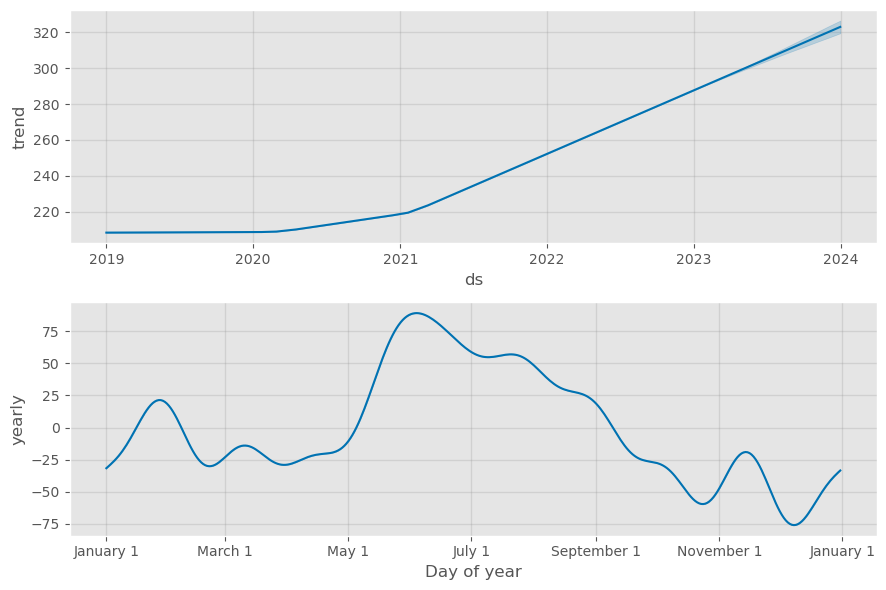

In [30]:
model_no_holiday.plot_components(forecast);

In [31]:
metric_df_1 = pd.concat([forecast_no_holiday[['ds','yhat']],prophet_df['y']], axis=1)
metric_df_1.head()

,ds,yhat,y
0,2019-01-01,283.045244,13.0
1,2019-01-02,255.748994,307.0
2,2019-01-03,241.027446,251.0
3,2019-01-04,219.612998,224.0
4,2019-01-05,-15.763423,19.0


In [32]:
metric_df_1.dropna(inplace = True)
print("R-squared: ", r2_score(metric_df_1['y'], metric_df_1['yhat']))
print("Mean Squared Error: ", mean_squared_error(metric_df_1['y'], metric_df_1['yhat']))
print("RMSE: ", np.sqrt(mean_squared_error(metric_df_1['y'], metric_df_1['yhat'])))

R-squared:  0.6151287264492513
Mean Squared Error:  11028.167422188359
RMSE:  105.01508187964411


# Prophet Holiday Model 2.0
<a id='Prophet_2'></a>

---
- Buffalo is a unique place to live so this model will include popular "Buffalo holidays" including Dyngus day and 7-1-6 day<br>
- Create a Prophet model including holidays and without weekly seasonality<br>
- Model for 12 months<br>
- Use the model to create predictions<br>
- Plot the model<br>
- Plot model components<br>

In [34]:
buff_holidays_dict = {'holiday': ["dyngus_day","dyngus_day","dyngus_day","dyngus_day","7-1-6 Day","7-1-6 Day","7-1-6 Day","7-1-6 Day",], 
                      'ds': [datetime.datetime(2019,4,29),datetime.datetime(2020,4,20),datetime.datetime(2021,5,3),datetime.datetime(2022,4,18),
                            datetime.datetime(2019,7,16),datetime.datetime(2020,7,16),datetime.datetime(2021,7,16),datetime.datetime(2022,7,16),], 
                      'lower_window':0,
                      'upper_window':0}

buff_holiday_df = pd.DataFrame(buff_holidays_dict)

all_holidays = pd.concat([holidays, buff_holiday_df],axis=0)

all_holidays.tail()

,holiday,ds,lower_window,upper_window
3,dyngus_day,2022-04-18,0,0
4,7-1-6 Day,2019-07-16,0,0
5,7-1-6 Day,2020-07-16,0,0
6,7-1-6 Day,2021-07-16,0,0
7,7-1-6 Day,2022-07-16,0,0


In [35]:
model_2 = Prophet(holidays=all_holidays,
                weekly_seasonality=False)

model_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_2.fit(prophet_df)

12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future = model_2.make_future_dataframe(periods=12, freq = 'm')
future.tail()
forecast_model_2 = model_2.predict(future)
forecast_model_2.head().T

,0,1,2,3,4
ds,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00
trend,209.865005,209.860939,209.856872,209.852806,209.84874
yhat_lower,-182.834368,-10.840113,2.380096,-11.420066,-4.623433
yhat_upper,221.899007,395.764883,406.393017,395.633517,405.331633
trend_lower,209.865005,209.860939,209.856872,209.852806,209.84874
...,...,...,...,...,...
yearly_upper,-15.859912,-14.689117,-13.75349,-13.009862,-12.411413
multiplicative_terms,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_lower,0.0,0.0,0.0,0.0,0.0
multiplicative_terms_upper,0.0,0.0,0.0,0.0,0.0


In [37]:
forecast_model_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1463,2023-08-31,333.039714,143.738358,530.852351
1464,2023-09-30,282.148180,95.089456,490.293236
1465,2023-10-31,257.534657,54.184348,449.840829
1466,2023-11-30,263.527920,61.821244,454.233630
1467,2023-12-31,303.542379,87.206978,485.612189


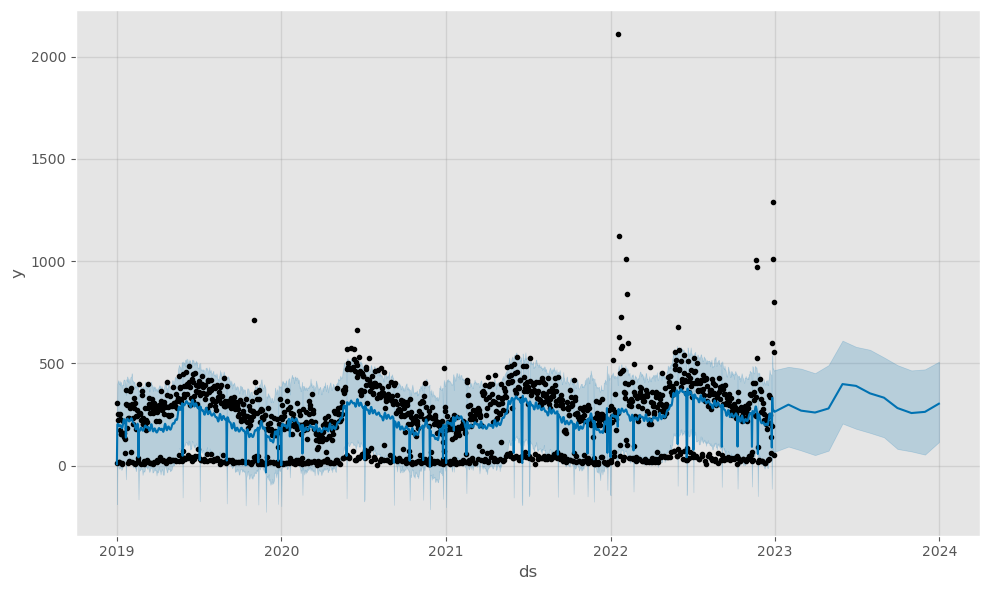

In [38]:
model_2.plot(forecast);

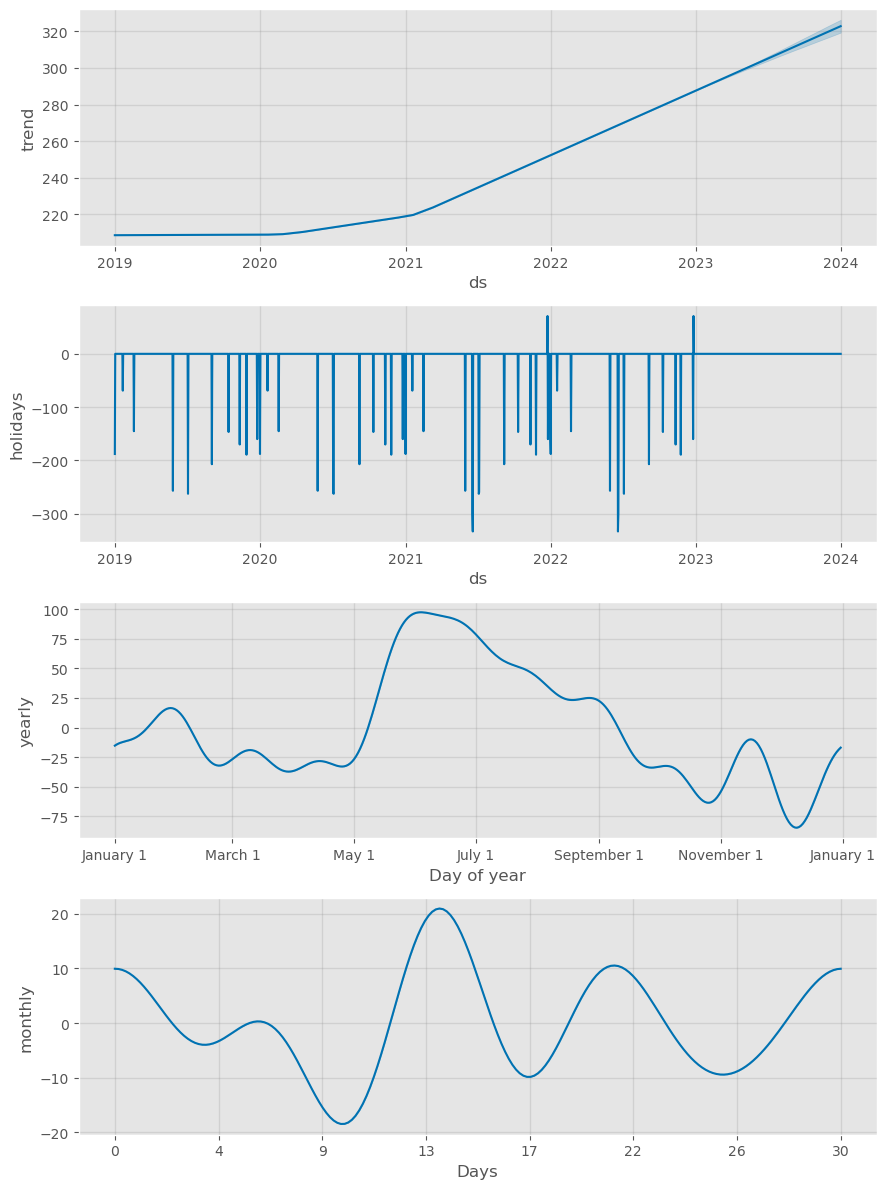

In [39]:
model_2.plot_components(forecast);

In [40]:
metric_df_2 = pd.concat([forecast_model_2[['ds','yhat']],prophet_df['y']], axis=1)
metric_df_2.head()

,ds,yhat,y
0,2019-01-01,7.089144,13.0
1,2019-01-02,202.773791,307.0
2,2019-01-03,206.030856,251.0
3,2019-01-04,204.540465,224.0
4,2019-01-05,199.708279,19.0


In [42]:
metric_df_2.dropna(inplace = True)
print("R-squared: ", r2_score(metric_df_2['y'], metric_df_2['yhat']))
print("Mean Squared Error: ", mean_squared_error(metric_df_2['y'], metric_df_2['yhat']))
print("RMSE: ", np.sqrt(mean_squared_error(metric_df_2['y'], metric_df_2['yhat'])))

R-squared:  0.13420323540287538
Mean Squared Error:  24808.688851928782
RMSE:  157.50774219678468


# Model Comparisons
<a id='Comparison'></a>

---
- Create joint dataframes<br>
- Compare models

In [43]:
forecast.set_index('ds', inplace=True)
forecast_no_holiday.set_index('ds', inplace=True)
compared_df = forecast.join(forecast_no_holiday, rsuffix="_no_holiday")

In [44]:
compared_df = compared_df[['yhat', 'yhat_no_holiday']]
compared_df.head()

,yhat,yhat_no_holiday
ds,,
2019-01-01,6.630328,283.045244
2019-01-02,200.940909,255.748994
2019-01-03,203.918670,241.027446
2019-01-04,202.373062,219.612998
2019-01-05,197.713909,-15.763423


In [45]:
compared_df['diff_per'] = 100 * (compared_df['yhat'] - compared_df['yhat_no_holiday']) / compared_df['yhat_no_holiday']
print("difference: ", round(compared_df.diff_per.mean(), 2), "%")

difference:  -0.68 %
